<a href="https://colab.research.google.com/github/24JE0305/Insurance-Charge-Predictor__/blob/main/Linear_by_sheriyan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Library and Data

In [139]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import seaborn as sns

## for model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression

In [140]:
df = pd.read_csv('insurance.csv')

## EDA

In [141]:
df.shape

(1338, 7)

In [142]:
df.isnull().sum().sum()

np.int64(0)

In [143]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [144]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [145]:
df.duplicated().sum()

np.int64(1)

We can drop One duplicate, There will be no issues with data due to that...

In [146]:
df.drop_duplicates(inplace=True)

In [147]:
df.shape

(1337, 7)

In [148]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


We can see there are 2 Numerical & 4 categorical cols

**Let's have look at the data**

In [150]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [151]:
categorical_col = ['sex','children','smoker', 'region']
numerical_col = ['age','bmi','charges']   ## charge is target

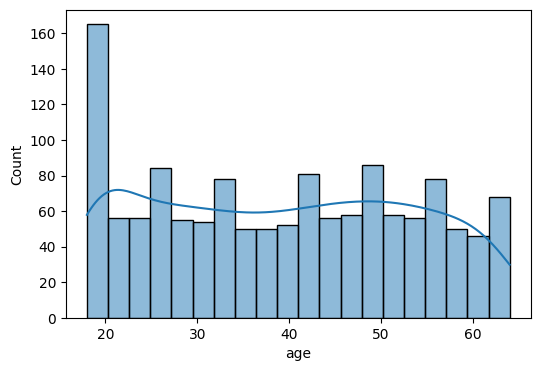

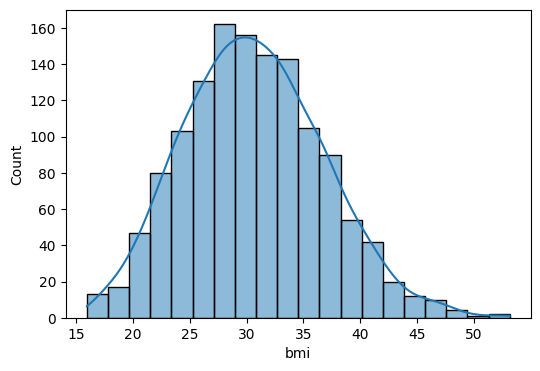

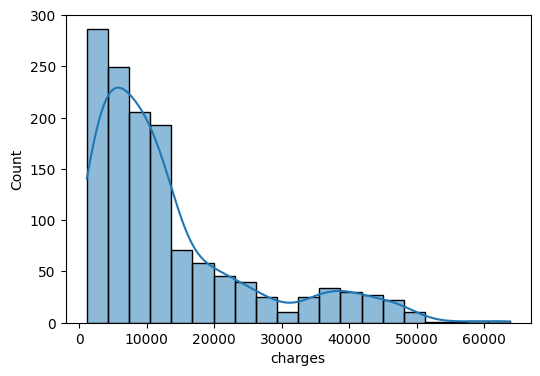

In [152]:
for col in numerical_col:
  plt.figure(figsize = (6,4))
  sns.histplot(df[col],kde = True , bins = 20)

**BMI** look impressive. (normal distributed)

In [153]:
df['children'].value_counts()

,count
children,
0,573
1,324
2,240
3,157
4,25
5,18


Look's ok

In [154]:
df['region'].value_counts()

,count
region,
southeast,364
southwest,325
northwest,324
northeast,324


perfect

In [155]:
df['smoker'].value_counts()

,count
smoker,
no,1063
yes,274


In [156]:
df['sex'].value_counts()

,count
sex,
male,675
female,662


ok

Now we need to do encoding of categorical data

In [157]:
df['sex'] = df['sex'].map({'male':1,'female':0})

In [158]:
df['smoker'] = df['smoker'].map({'yes':1,'no':0})

In [159]:
df = pd.get_dummies(df,columns = ['region'],drop_first=True).astype(int)

## Data Preprocessing

Now using standard scalar to normalize data

In [160]:
cols_to_scale = ['age','bmi','children']

scalar = StandardScaler()
df[cols_to_scale] = scalar.fit_transform(df[cols_to_scale])

In [161]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'charges',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')

In [162]:
selected_features = [
    'age', 'sex', 'bmi', 'children', 'smoker',
    'region_northwest', 'region_southeast', 'region_southwest'
]

df[selected_features + ['charges']].corr()['charges'].sort_values(ascending=False)


,charges
charges,1.000000
smoker,0.787234
age,0.298309
bmi,0.196236
region_southeast,0.073577
children,0.067390
sex,0.058046
region_northwest,-0.038695
region_southwest,-0.043637


we know that it is only good for numerical to numerical data

In [163]:
cat_cols = ['sex', 'children', 'smoker','region_northwest', 'region_southeast', 'region_southwest']

In [164]:
mi_values = mutual_info_regression(df[cat_cols],df['charges'])

In [165]:
mi_results = pd.DataFrame({
    'Feature': cat_cols,
    'Mutual Information' : mi_values
}).sort_values(by = 'Mutual Information',ascending= False)

In [166]:
mi_results

,Feature,Mutual Information
2,smoker,0.369537
0,sex,0.176054
1,children,0.161756
3,region_northwest,0.056472
4,region_southeast,0.032206
5,region_southwest,0.003118


**We will try to train model based on not removing and removing usless columns**

for now our final df is ready

## Model Training

In [167]:
X = df.drop('charges',axis = 1)
Y = df['charges']

In [168]:
# Step 1: Train (80%) + Temp (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=42)

In [169]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1069, 8)
(1069,)
(268, 8)
(268,)


In [170]:
model = LinearRegression()

model.fit(X_train,y_train)

LinearRegression()

model without features selection

In [171]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# ---- Train performance ----
train_pred = model.predict(X_train)
train_r2 = r2_score(y_train, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

# ---- CV performance ----
cv_pred = model.predict(X_test)
cv_r2 = r2_score(y_test, cv_pred)
cv_rmse = np.sqrt(mean_squared_error(y_test, cv_pred))

print("Train R2:", train_r2)
print("Train RMSE:", train_rmse)
print("CV R2:", cv_r2)
print("CV RMSE:", cv_rmse)


Train R2: 0.7298693010380308
Train RMSE: 6081.518501257835
CV R2: 0.8069435680345955
CV RMSE: 5956.114013592358


model with feature selection

In [172]:
X_train_new = X_train.drop(['region_southeast','region_southwest'],axis =1)

In [173]:
X_test_new = X_test.drop(['region_southeast','region_southwest'],axis =1)

In [174]:
Model2 = LinearRegression()

In [175]:
Model2.fit(X_train_new,y_train)

LinearRegression()

In [177]:
# ---- Train performance ----
train_pred = Model2.predict(X_train_new)
train_r2 = r2_score(y_train, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

# ---- CV performance ----
cv_pred = Model2.predict(X_test_new)
cv_r2 = r2_score(y_test, cv_pred)
cv_rmse = np.sqrt(mean_squared_error(y_test, cv_pred))

print("Train R2:", train_r2)
print("Train RMSE:", train_rmse)
print("test R2:", cv_r2)
print("test RMSE:", cv_rmse)

Train R2: 0.7291835597833767
Train RMSE: 6089.232738910662
test R2: 0.8048399178480257
test RMSE: 5988.476656515611
